In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

import sys
sys.path.append("../")

import mitsuba as mi
import drjit as dr
from matplotlib import pyplot as plt
import numpy as np
import skimage as ski
from scipy import ndimage as ndi
from helpers.polarization_helpers import *
from helpers.render_helpers import *
from helpers.hair_color_helpers import *

print(mi.variants())
mi.set_variant("cuda_ad_spectral_polarized")
dr.set_flag(dr.JitFlag.Debug, True)

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']


In [3]:
scene = mi.load_file("../../scenes/marcus_light_sphere_hair.xml")

In [9]:
position = [0, 0, 75]
spp = 1
res = 512

integrator = mi.load_dict({
	"type": "depth"
})

sensor = mi.load_dict({
	"type": "perspective",
	"to_world": mi.ScalarTransform4f().look_at(origin=position, target=[0,0,0], up=[0,1,0]),
	"sampler": {
		"type": "independent",
		"sample_count": spp
	},
	"film": {
		"type": "hdrfilm",
		"width": res,
		"height": res,
		"rfilter": {
			"type": "tent"
		}
	}
})

In [6]:
radius = 75
theta = 0.5*np.pi
phi = 0

In [10]:
params = mi.traverse(scene)

# Save old transforms
polarizer_light_transform = mi.Transform4f(params["polarizer_light.to_world"])
polarizer_cam_transform = mi.Transform4f(params["polarizer_cam.to_world"])

# Move polarizers away
params["polarizer_light.to_world"] = mi.Transform4f().translate([0, 10000, 0])
params["polarizer_cam.to_world"] = mi.Transform4f().translate([0, 10000, 0])
params.update()

# Calculate maximum distance of vertices to camera
head_positions = np.array(params["head.vertex_positions"]).reshape(3, -1)
hair_positions = np.array(params["hair.control_points"]).reshape(4, -1)[:3, :]

head_dist = np.linalg.norm(head_positions, ord=2, axis=0)
hair_dist = np.linalg.norm(hair_positions, ord=2, axis=0)

threshold = radius + max(head_dist.max(), hair_dist.max())

integrator = mi.load_dict({
	"type": "depth"
})

# images = render_from_angle(scene, radius, theta, phi, polarized=False, spp=128, integrator=integrator)
images = mi.render(scene, sensor=sensor, integrator=integrator).numpy()
images = np.average(images, axis=-1) # convert to grayscale

mask = np.where(images > threshold, 0.0, 1.0)

# Undo changes to scenes
params["polarizer_light.to_world"] = polarizer_light_transform
params["polarizer_cam.to_world"] = polarizer_cam_transform
_ = params.update()

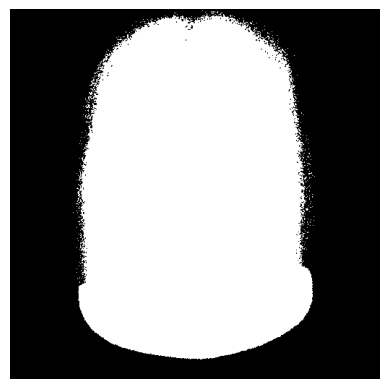

In [11]:
plt.imshow(mask.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

In [5]:
img = mi.render(scene, sensor=sensor, integrator=integrator).numpy()
img.shape

(512, 512, 3)

In [71]:
image = img[..., :3]
pos = img[..., 3:]

params = mi.traverse(scene)

# Calculate maximum distance of vertices to camera
head_positions = np.array(params["head.vertex_positions"]).reshape(3, -1)
hair_positions = np.array(params["hair.control_points"]).reshape(4, -1)[:3, :]

head_dist = np.linalg.norm(head_positions, ord=2, axis=0)
hair_dist = np.linalg.norm(hair_positions, ord=2, axis=0)

threshold = max(head_dist.max(), hair_dist.max()) * 1.1

mask = np.where(np.linalg.norm(pos, ord=2, axis=-1) > threshold, 0.0, 1.0)

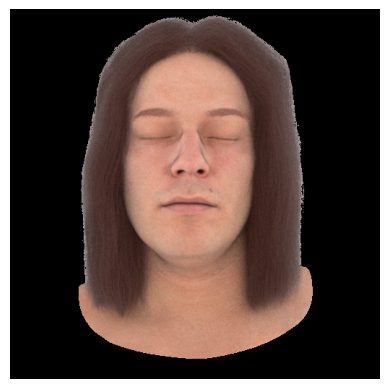

In [72]:
masked = image * mask[..., None]
plt.imshow(np.clip(masked, 0.0, 1.0) ** (1.0 / 2.2))
plt.axis("off")
plt.show()

In [73]:
params = mi.traverse(scene)

# Save old transforms
polarizer_light_transform = mi.Transform4f(params["polarizer_light.to_world"])
polarizer_cam_transform = mi.Transform4f(params["polarizer_cam.to_world"])

# Move polarizers away
params["polarizer_light.to_world"] = mi.Transform4f().translate([0, 10000, 0])
params["polarizer_cam.to_world"] = mi.Transform4f().translate([0, 10000, 0])
params.update()

# Calculate maximum distance of vertices to camera
head_positions = np.array(params["head.vertex_positions"]).reshape(3, -1)
hair_positions = np.array(params["hair.control_points"]).reshape(4, -1)[:3, :]

head_dist = np.linalg.norm(head_positions, ord=2, axis=0)
hair_dist = np.linalg.norm(hair_positions, ord=2, axis=0)

threshold = radius + max(head_dist.max(), hair_dist.max())

integrator = mi.load_dict({
	"type": "depth"
})

images = render_from_angle(scene, radius, theta, phi, polarized=False, spp=128, integrator=integrator)
images = np.average(images, axis=-1) # convert to grayscale

mask = np.where(images > threshold, 0.0, 1.0)

# Undo changes to scenes
params["polarizer_light.to_world"] = polarizer_light_transform
params["polarizer_cam.to_world"] = polarizer_cam_transform
_ = params.update()

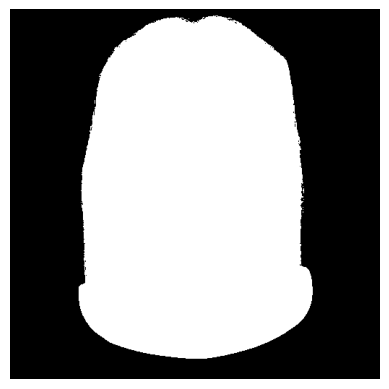

In [74]:
plt.imshow(mask.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

In [63]:
params = mi.traverse(scene)

# Save old transforms
polarizer_cam_transform = mi.Transform4f(params["polarizer_cam.to_world"])

# Move polarizers away
params["polarizer_cam.to_world"] = mi.Transform4f().translate([0, 10000, 0])
params.update()

image = render_from_angle(scene, radius, theta, phi, polarized=False, spp=128)

# Undo changes to scenes
params["polarizer_cam.to_world"] = polarizer_cam_transform
_ = params.update()

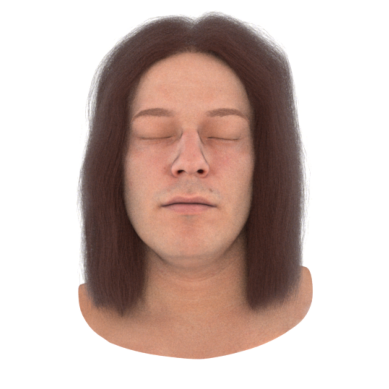

In [64]:
plt.imshow(np.clip(image.squeeze(), 0.0, 1.0) ** (1.0 / 2.2))
plt.axis("off")
plt.show()

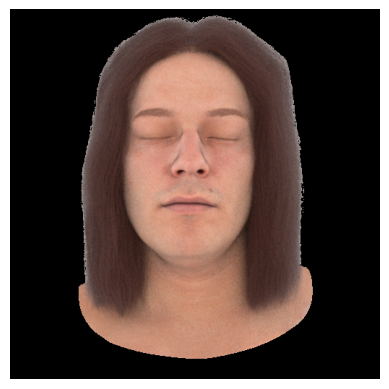

In [75]:
masked = image * mask[..., None]
plt.imshow(np.clip(masked.squeeze(), 0.0, 1.0) ** (1.0 / 2.2))
plt.axis("off")
plt.show()